# Regression discontinuity design

#### Members:
- Cian Monnin
- Franck E Dominique
- Antonio Nardi
- Sabine Hong

## Prompt

Our task is to use Regression discontinuity design (RDD) to estimate the effect of the following events in Quebec:

- The 20/3/2020 lockdown

- The reopening of schools on 31/8/2020

- The 25/12/2020 lockdown

# Setup

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import datetime

import statsmodels.formula.api as smf

from custom_functions import rdd_plot, diff_rdd_fig, vax_plot, overview_plot, coef_p_table

## Read CSV

In [2]:
# data obtained from the Ministère de la Santé et des Services sociaux
# dataset: Historique du portrait quotidien des cas confirmésCSV
# accessed 2023-02-21
# url: https://www.donneesquebec.ca/recherche/dataset/covid-19-portrait-quotidien-des-cas-confirmes/resource/d2cf4211-5400-46a3-9186-a81e6cd41de9

data = pd.read_csv('QC_COVID.csv')
print(len(data), 'rows')
data.sample(5)

1126 rows


,Date,Nb_Cas_Cumulatif,Nb_Nvx_Cas,Nb_Deces_Cumulatif_Total,Nb_Deces_Cumulatif_CHCHSLD,Nb_Deces_Cumulatif_RPA,Nb_Deces_Cumulatif_DomInc,Nb_Deces_Cumulatif_Autre,Nb_Nvx_Deces_Total,Nb_Nvx_Deces_CHCHSLD,Nb_Nvx_Deces_RPA,Nb_Nvx_Deces_DomInc,Nb_Nvx_Deces_Autre
1094,2023-01-20,1298392,453,17852,6851,3434,6793,774,12,1,1,10,0
591,2021-09-04,388214,631,11308,5738,2382,2608,580,0,0,0,0,0
688,2021-12-10,458591,2029,11634,5777,2433,2839,585,5,1,0,4,0
739,2022-01-30,863808,2516,13462,6111,2714,3971,666,33,6,4,22,1
703,2021-12-25,547901,10582,11716,5780,2440,2906,590,15,2,2,10,1


## Clean Data

### Remove Unused Columns

In [3]:
data = data[['Date', 'Nb_Nvx_Cas']].copy() # Date and New_Cases
data.columns

Index(['Date', 'Nb_Nvx_Cas'], dtype='object')

Since we are only interested in the new COVID cases per day, we can remove the rest of the columns. The unused columns include data on cumulative cases since the start of the pandemic and deaths in the different types of environments (CHCHSLD, DomInc and RPA).

### Translate Columns

In [4]:
data.columns = ['Date', 'New_Cases']
data.columns

Index(['Date', 'New_Cases'], dtype='object')

### Fix Data Types

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126 entries, 0 to 1125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1126 non-null   object
 1   New_Cases  1126 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.7+ KB


Considering the context of the project, we will only need two columns: Date and New_Cases

In [6]:
# Convert Date column to Datetime
data = data[data.Date != 'Date inconnue'].copy()
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.dtypes

Date         datetime64[ns]
New_Cases             int64
dtype: object

# Data Exploration

## Full Chart

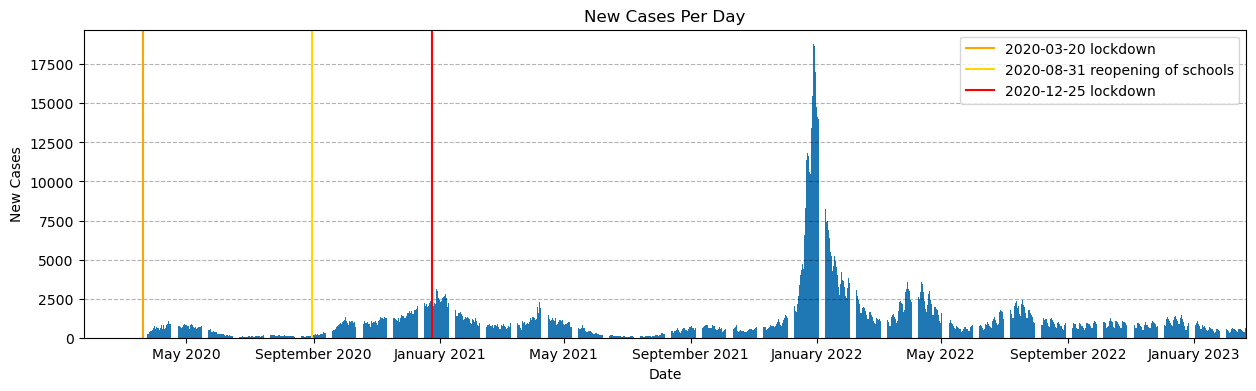

In [7]:
fig, ax = plt.subplots(figsize=(15,4))

# Build the bar chart
ax.bar(data['Date'], data['New_Cases'])

# Important Dates to Check
ax.axvline(datetime.datetime(2020, 3, 20), color='orange', label='2020-03-20 lockdown') # Lockdown 1
ax.axvline(datetime.datetime(2020, 8, 31), color='gold', label='2020-08-31 reopening of schools') # Reopen Schools
ax.axvline(datetime.datetime(2020, 12, 25), color='red', label='2020-12-25 lockdown') # Lockdown 2

# Format the plot
ax.set_xlabel('Date')
ax.set_ylabel('New Cases')
ax.set_title('New Cases Per Day')
ax.legend()
ax.grid(True, 'major', axis='y', color='black',alpha=0.3,linestyle='--')
ax.margins(x=0)
myFmt = mdates.DateFormatter('%B %Y')
ax.xaxis.set_major_formatter(myFmt)

## Zoomed In Chart

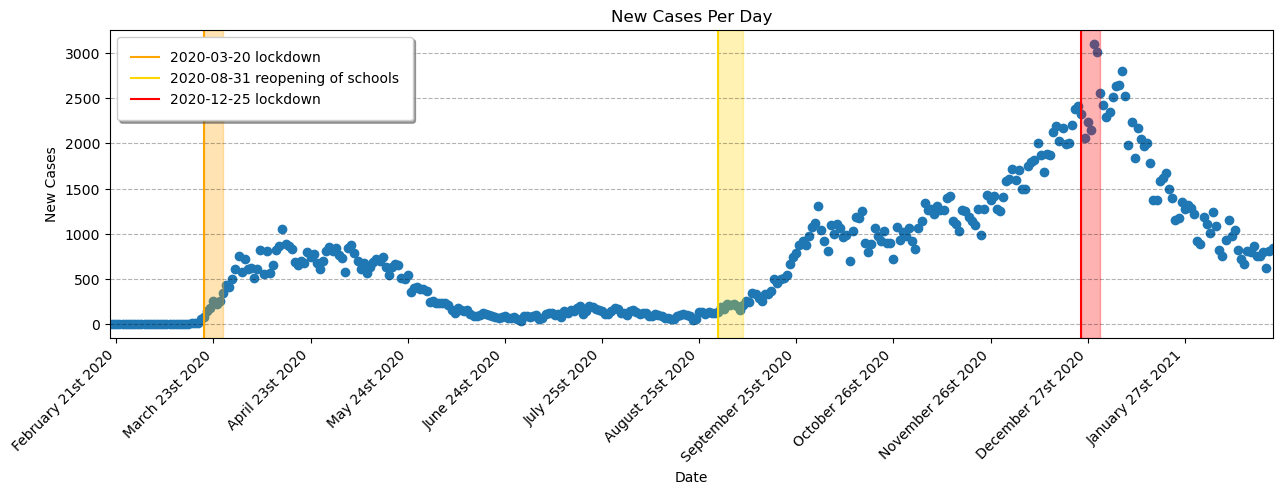

In [8]:
fig, ax = plt.subplots(figsize=(15,4))

# Zoom into the portion of the data that is part of the project
plot_data = data.loc[
    (data['Date'] > '2020-2-18')
    & 
    (data['Date'] < '2021-2-25')
     ]

# Build the scatter plot
ax.scatter(plot_data['Date'], plot_data['New_Cases'])

#### Important Dates to Check
ax.axvline(datetime.datetime(2020, 3, 20), color='orange', label='2020-03-20 lockdown') # Lockdown 1
ax.axvspan(datetime.datetime(2020, 3, 20), datetime.datetime(2020, 3, 26), alpha=0.3, color='orange') # incubation period

ax.axvline(datetime.datetime(2020, 8, 31), color='gold', label='2020-08-31 reopening of schools') # Reopen Schools
ax.axvspan(datetime.datetime(2020, 8, 31), datetime.datetime(2020, 9, 8), alpha=0.3, color='gold') # incubation period

ax.axvline(datetime.datetime(2020, 12, 25), color='red', label='2020-12-25 lockdown') # Lockdown 2
ax.axvspan(datetime.datetime(2020, 12, 25), datetime.datetime(2020, 12, 31), alpha=0.3, color='red') # incubation period

# Format the plot
ax.set_xlabel('Date')
ax.set_ylabel('New Cases')
ax.set_title('New Cases Per Day')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
ax.grid(True, 'major', axis='y', color='black',alpha=0.3,linestyle='--')
ax.margins(x=0)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=31))
myFmt = mdates.DateFormatter('%B %dst %Y')
ax.xaxis.set_major_formatter(myFmt)

## Initial Assessment

Visually, it looks like our regression lines should focus on three sections, which start at each point of interest:

- Regression 1 --> Mid-March 2020 to mid-May 2020

- Regression 2 --> August 2020 to end of September 2020 

- Regression 3 --> Mid-December 2020 to end of January 2021

# Regression

## Design Justification 

The data source was obtained from the Ministère de la Santé et des Services sociaux. This was expected to be a relatively complete and reliable data source. 

Determination of cut-offs (thresholds) for the RDDs. 

RRDs are used to determine causal effects of interventions. In this case the effect of either lockdowns or schools reopening on COVID-19 cases. Tan et al. showed that with a median age of 42 years the median incubation time was 5 days. The median age of the population of Quebec is 43.1 years [2]. This is a good match to the age in the study.  Tung Ho et al. [3] determined that the median incubation time in children was longer than it was for adults. This median incubation time in children was 7 days.

For these reasons we chose to have our initial thresholds for our RDD lockdown models to be 5 days after the lockdowns were implemented. However after modelling this thresholds did not prove adequate for our fits. Due to the nature of the data being real-world cases some flexibility in the threshold choice was required. 

Our final choice of threshold for lockdown 1 was chosen to be on 2020-04-14. For the school reopening we went with a threshold of 2020-09-20. For lockdown 2 a threshold date of 2021-01-09 was selected. 

## Lockdown 1

### Linear Model

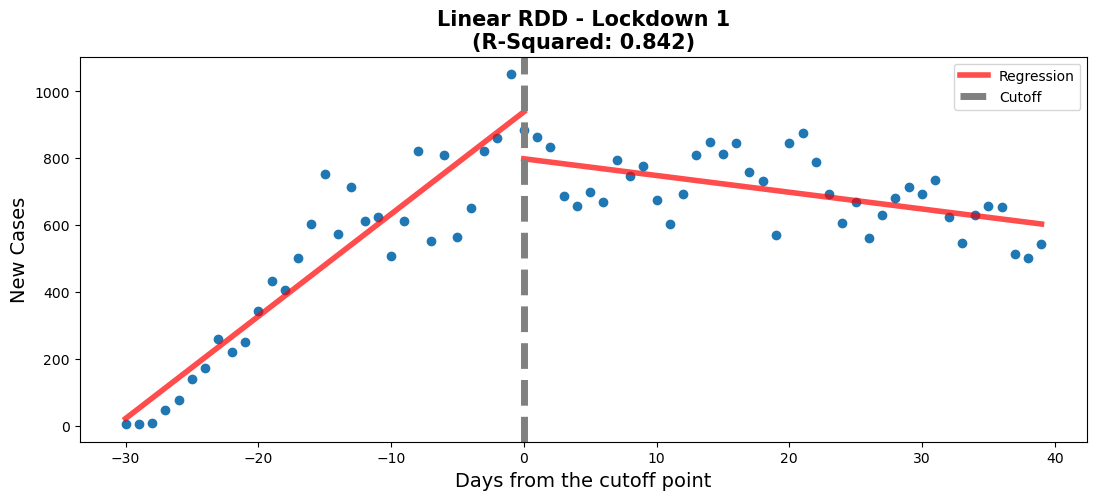

In [9]:
#regression 1 - lockdown 1
#Lockdown date: 20/3/2020
#create new df for this regression
df_rg1 = data[['Date','New_Cases']].copy()
#set date range of interest
df_rg1 = df_rg1.loc[
    (df_rg1['Date'] > '2020-3-15')
    & 
    (df_rg1['Date'] < '2020-5-25')
     ]
#create a new column to plot on the x-axis and allow us to centre
df_rg1['Time'] = np.arange(len(df_rg1['Date']))
#creating the centre point which will be the threshold of the two regressions
df_rg1['Time'] -= 30
df_rg1 = df_rg1.assign(threshold=(df_rg1["Time"] > 0).astype(int))

#create a weighted-least-squares model
model = smf.ols(formula='New_Cases~Time*threshold',data=df_rg1).fit()

# Get pvalues
info_m1 = model.pvalues.to_frame().rename(
    {0: 'Linear Model'}, axis=1).T

# Visualize model
fig,ax = plt.subplots(figsize=(13, 5))
rdd_plot(df_rg1, model, ax, 'Linear RDD - Lockdown 1')

### Polynomial Model

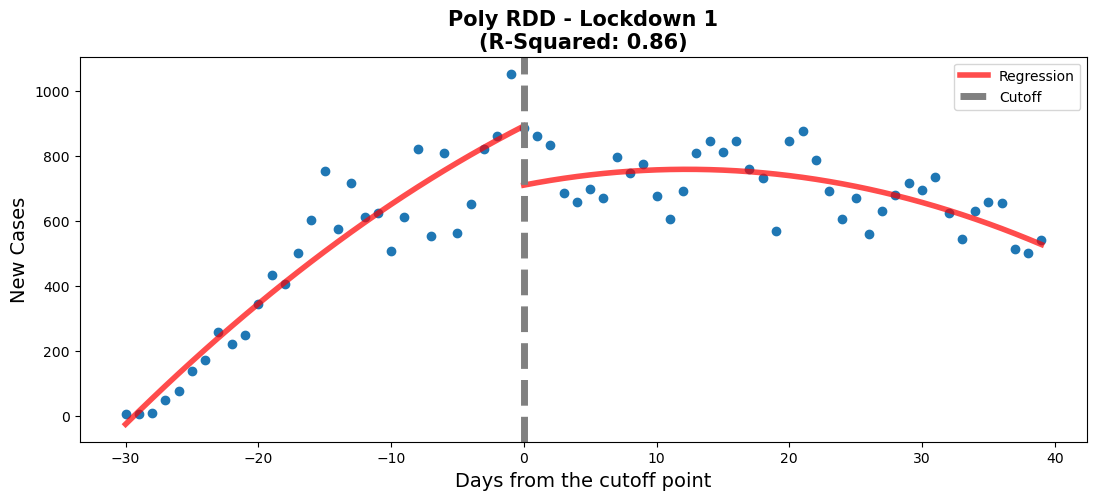

In [10]:
#regression 1 - lockdown 1
#Lockdown date: 20/3/2020
#create new df for this regression
df_rg1 = data[['Date','New_Cases']].copy()
#set date range of interest
df_rg1 = df_rg1.loc[
    (df_rg1['Date'] > '2020-3-15')
    & 
    (df_rg1['Date'] < '2020-5-25')
     ]
#create a new column to plot on the x-axis and allow us to centre
df_rg1['Time'] = np.arange(len(df_rg1['Date']))
#creating the centre point which will be the threshold of the two regressions
df_rg1['Time'] -= 30
df_rg1 = df_rg1.assign(threshold=(df_rg1["Time"] > 0).astype(int))

#create a weighted-least-squares model
model_poly = smf.ols(formula='New_Cases~Time*threshold + I(Time**2)',data=df_rg1).fit()

# Get pvalues
info_pm1 = model_poly.pvalues.to_frame().rename(
    {0: 'Poly Model'}, axis=1).T

# Add row to model info
info_m1 = pd.concat([info_m1, info_pm1], axis=0).reset_index().rename(columns={'index':'Model'})

# Visualize model
fig,ax = plt.subplots(figsize=(13, 5))
rdd_plot(df_rg1, model_poly, ax, 'Poly RDD - Lockdown 1')

### Model Selection

/home/fame/Projects/COVID_RDD/custom_functions.py:166: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=2)


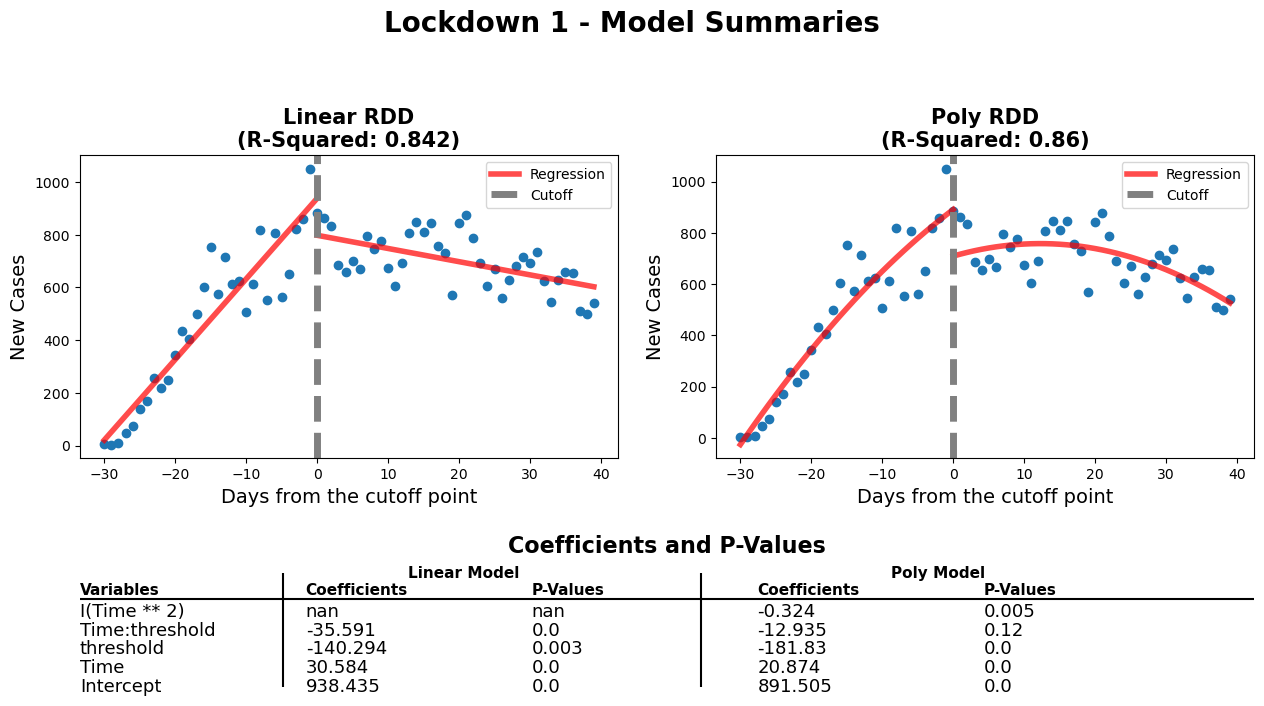

In [11]:
lin_coefs = model.params.to_frame().reset_index().rename({0: 'Linear Model coef', 'index': 'Variables'}, axis=1)
poly_coefs = model_poly.params.to_frame().reset_index().rename({0: 'Poly Model coef', 'index': 'Variables'}, axis=1)
coefs = lin_coefs.merge(poly_coefs, on='Variables', how='right').round(3)

info_m1 = info_m1.set_index('Model').T.reset_index().rename({'index': 'Variables'}, axis=1)
model_info = coefs.merge(info_m1, on='Variables', how='outer').set_index('Variables')
model_info = model_info[['Linear Model coef', 'Linear Model', 'Poly Model coef', 'Poly Model']]
model_info.columns = [
    ['Linear Model', 'Linear Model', 'Poly Model', 'Poly Model'],
    ['Coefficients', 'P-Values', 'Coefficients', 'P-Values']
]
model_info = model_info.reset_index()

diff_rdd_fig(
    df_rg1, model, model_poly, 
    model_info, 
    'Lockdown 1 - Model Summaries'
)

When comparing both models, we need to verify that every variable is statistically significant using the p-values. For the linear model, the p-values for every variable is close to 0, which means that they're all statistically significant. Also, the threshold for the linear model appears to be well positioned according to the p-value. When it comes to the polynomial model, there is one variable which has a p-value above 0.05. This means that the 'Time:threshold' variable is statistically insignificant. Therefore, even though the polynomial model has a better r-squared value, the **linear model** is better in this case.

## Reopening of schools

### Linear Model

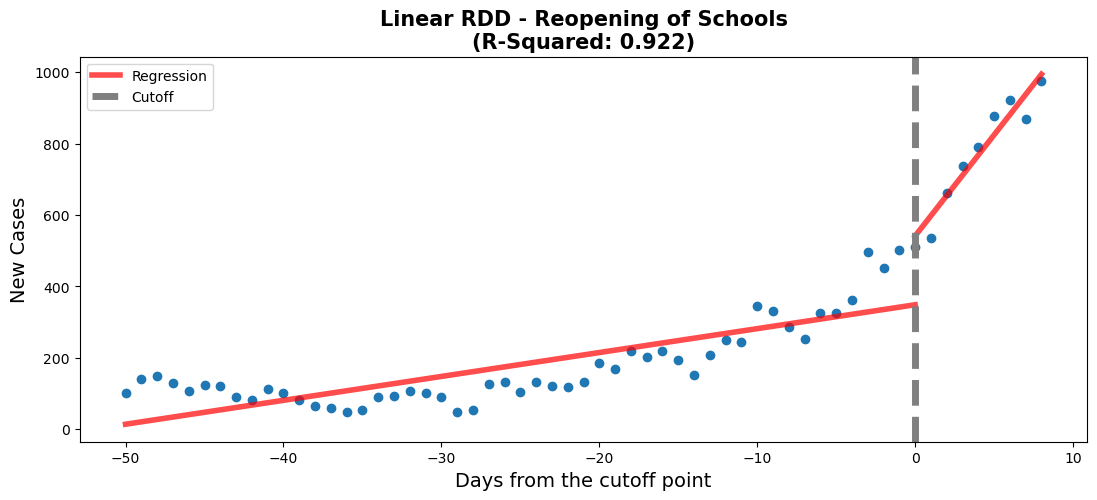

In [12]:
#regression 2 - Reopening of schools
#School opening 31/8/2020

#create new df for this regression
df_rg2 = data[['Date','New_Cases']].copy()
#set date range of interest
df_rg2 = df_rg2.loc[
    (df_rg2['Date'] > '2020-8-1')
    & 
    (df_rg2['Date'] < '2020-9-30')
     ]

#create a new column to plot on the x-axis and allow us to centre 
df_rg2['Time'] = np.arange(len(df_rg2['Date']))
#creating the centre point which will be the threshold of the two regressions
df_rg2['Time'] -= 50# was 40
df_rg2 = df_rg2.assign(threshold=(df_rg2["Time"] > 0).astype(int))

#create a weighted-least-squares model
model2 = smf.ols(formula='New_Cases~Time*threshold',data=df_rg2).fit()

# Get pvalues
info_m2 = model2.pvalues.to_frame().rename(
    {0: 'Linear Model'}, axis=1).T

# Visualize model
fig,ax = plt.subplots(figsize=(13, 5))
rdd_plot(df_rg2, model2, ax, 'Linear RDD - Reopening of Schools')

### Polynomial Model

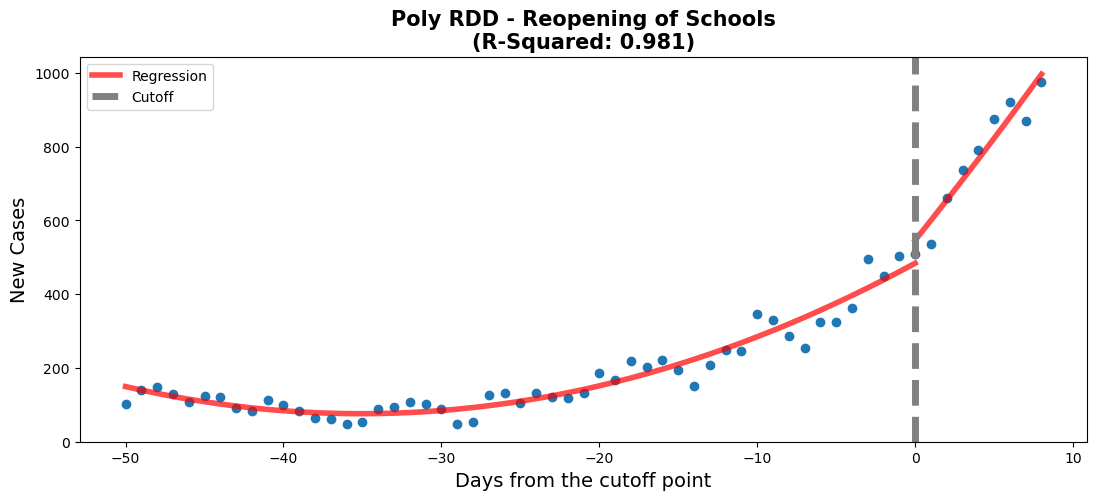

In [13]:
#regression 2 - Reopening of schools
#School opening 1/8/2020

#create new df for this regression
df_rg2 = data[['Date','New_Cases']].copy()
#set date range of interest
df_rg2 = df_rg2.loc[
    (df_rg2['Date'] > '2020-8-1')
    & 
    (df_rg2['Date'] < '2020-9-30')
     ]

#create a new column to plot on the x-axis and allow us to centre 
df_rg2['Time'] = np.arange(len(df_rg2['Date']))
#creating the centre point which will be the threshold of the two regressions
df_rg2['Time'] -= 50# was 40
df_rg2 = df_rg2.assign(threshold=(df_rg2["Time"] > 0).astype(int))

#create a weighted-least-squares model
model2_poly = smf.ols(formula='New_Cases~Time*threshold + I(Time**2)',data=df_rg2).fit()

# Get pvalues
info_pm2 = model2_poly.pvalues.to_frame().rename(
    {0: 'Poly Model'}, axis=1).T

# Add row to model info
info_m2 = pd.concat([info_m2, info_pm2], axis=0).reset_index().rename(columns={'index':'Model'})

# Visualize model
fig,ax = plt.subplots(figsize=(13, 5))
rdd_plot(df_rg2, model2_poly, ax, 'Poly RDD - Reopening of Schools')

### Model Selection

/home/fame/Projects/COVID_RDD/custom_functions.py:166: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=2)


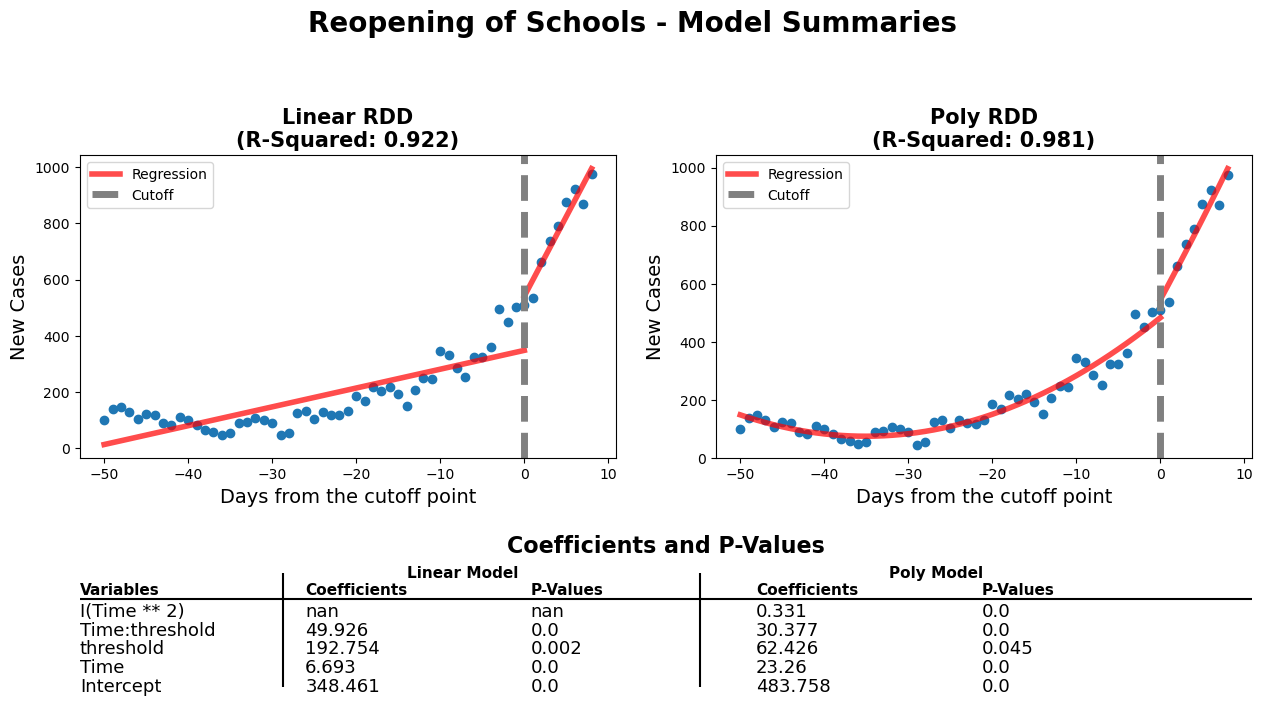

In [14]:
lin_coefs = model2.params.to_frame().reset_index().rename({0: 'Linear Model coef', 'index': 'Variables'}, axis=1)
poly_coefs = model2_poly.params.to_frame().reset_index().rename({0: 'Poly Model coef', 'index': 'Variables'}, axis=1)
coefs2 = lin_coefs.merge(poly_coefs, on='Variables', how='right').round(3)

info_m2 = info_m2.set_index('Model').T.reset_index().rename({'index': 'Variables'}, axis=1)
model2_info = coefs2.merge(info_m2, on='Variables', how='outer').set_index('Variables')
model2_info = model2_info[['Linear Model coef', 'Linear Model', 'Poly Model coef', 'Poly Model']]
model2_info.columns = [
    ['Linear Model', 'Linear Model', 'Poly Model', 'Poly Model'],
    ['Coefficients', 'P-Values', 'Coefficients', 'P-Values']
]
model2_info = model2_info.reset_index()

diff_rdd_fig(
    df_rg2, model2, model2_poly, 
    model2_info, 
    'Reopening of Schools - Model Summaries'
)

Firstly, when comparing the p-values of both models, we can see that they're all statistically significant. Also, when focusing on the threshold's p-values, the linear model has a slight edge. Secondly, the slopes have a more pronounced increase and the threshold coefficient is much higher on the linear model. The considerable differences will allow us to observe a more obvious change and with help us in the analysis portion of this report. Lastly, although the linear model has a slightly lower r-squared value, it is less complex and has characteristics (which are mentioned above) that make it more favourable. Due to these reasons, we chose the **linear model**.

## Lockdown 2

### Linear Model

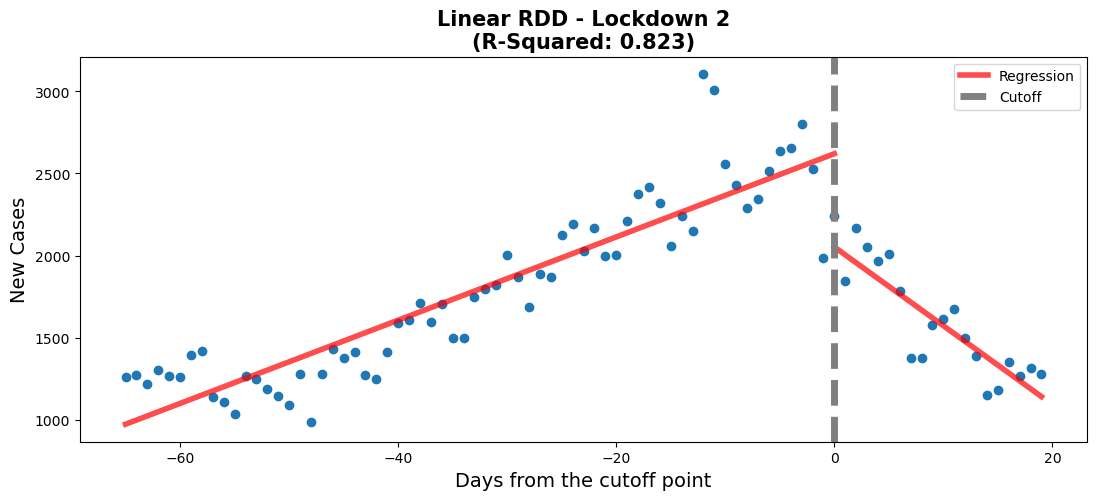

In [15]:
#regression 3 - Lockdown 2
#December 25th 2nd lockdown

#create new df for this regression
df_rg3 = data[['Date','New_Cases']].copy()
#set date range of interest
df_rg3 = df_rg3.loc[
    (df_rg3['Date'] > '2020-11-5')
    & 
    (df_rg3['Date'] < '2021-01-30')
     ]

#create a new column to plot on the x-axis and allow us to centre 
df_rg3['Time'] = np.arange(len(df_rg3['Date']))
#creating the centre point which will be the threshold of the two regression
df_rg3['Time'] -= 65 # original value was 45
df_rg3 = df_rg3.assign(threshold=(df_rg3["Time"] > 0).astype(int))

#create a weighted-least-squares model
model3 = smf.ols(formula='New_Cases~Time*threshold',data=df_rg3).fit()

# Get pvalues
info_m3 = model3.pvalues.to_frame().rename(
    {0: 'Linear Model'}, axis=1).T

# Visualize model
fig,ax = plt.subplots(figsize=(13, 5))
rdd_plot(df_rg3, model3, ax, 'Linear RDD - Lockdown 2')

### Polynomial Model

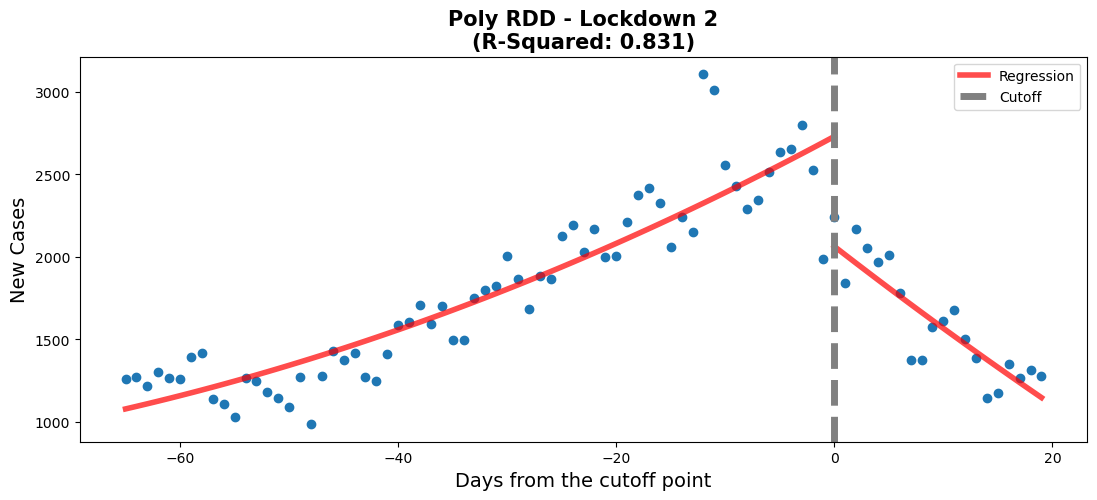

In [16]:
#regression 3 - Lockdown 2
#December 25th 2nd lockdown

#create new df for this regression
df_rg3 = data[['Date','New_Cases']].copy()
#set date range of interest
df_rg3 = df_rg3.loc[
    (df_rg3['Date'] > '2020-11-5')
    & 
    (df_rg3['Date'] < '2021-01-30')
     ]

#create a new column to plot on the x-axis and allow us to centre 
df_rg3['Time'] = np.arange(len(df_rg3['Date']))
#creating the centre point which will be the threshold of the two regression
df_rg3['Time'] -= 65 # original value was 45
df_rg3 = df_rg3.assign(threshold=(df_rg3["Time"] > 0).astype(int))

#create a weighted-least-squares model
model3_poly = smf.ols(formula='New_Cases~Time*threshold + I(Time**2)',data=df_rg3).fit()

# Get pvalues
info_pm3 = model3_poly.pvalues.to_frame().rename(
    {0: 'Poly Model'}, axis=1).T

# Add row to model info
info_m3 = pd.concat([info_m3, info_pm3], axis=0).reset_index().rename(columns={'index':'Model'})

# Visualize model
fig,ax = plt.subplots(figsize=(13, 5))
rdd_plot(df_rg3, model3_poly, ax, 'Poly RDD - Lockdown 2')

### Model Selection

/home/fame/Projects/COVID_RDD/custom_functions.py:166: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=2)


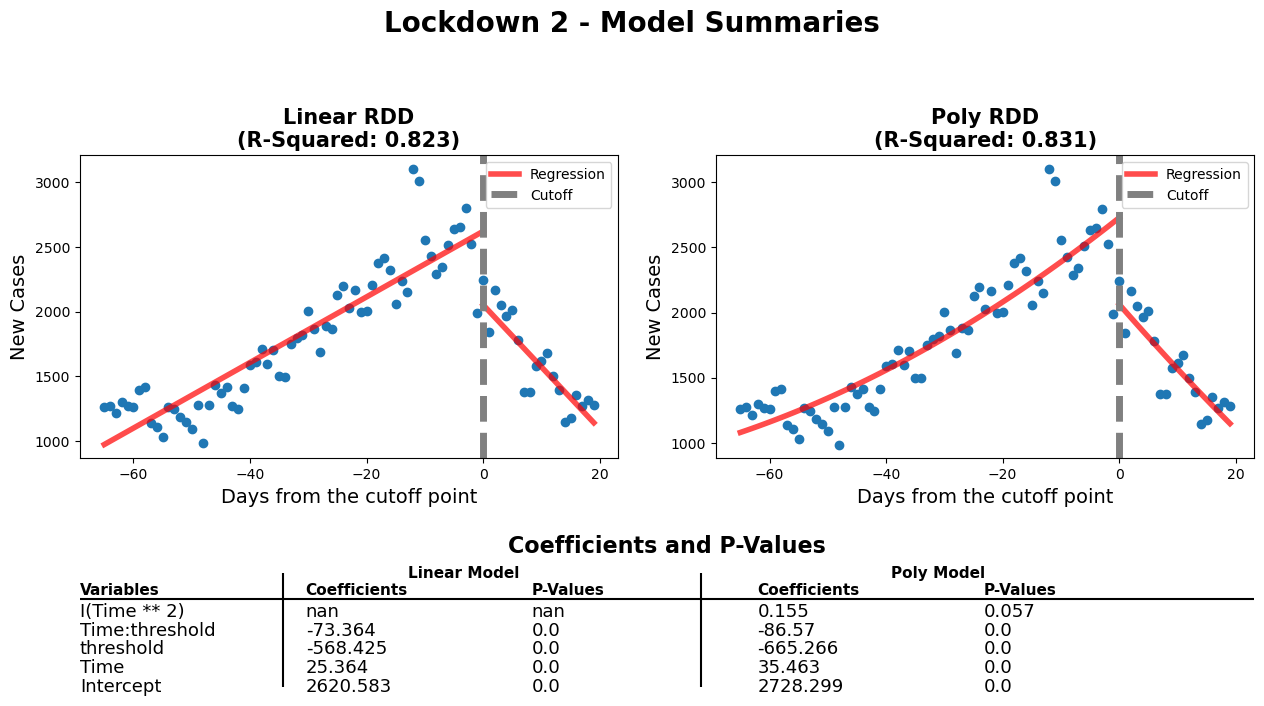

In [17]:
lin_coefs = model3.params.to_frame().reset_index().rename({0: 'Linear Model coef', 'index': 'Variables'}, axis=1)
poly_coefs = model3_poly.params.to_frame().reset_index().rename({0: 'Poly Model coef', 'index': 'Variables'}, axis=1)
coefs3 = lin_coefs.merge(poly_coefs, on='Variables', how='right').round(3)

info_m3 = info_m3.set_index('Model').T.reset_index().rename({'index': 'Variables'}, axis=1)
model3_info = coefs3.merge(info_m3, on='Variables', how='outer').set_index('Variables')
model3_info = model3_info[['Linear Model coef', 'Linear Model', 'Poly Model coef', 'Poly Model']]
model3_info.columns = [
    ['Linear Model', 'Linear Model', 'Poly Model', 'Poly Model'],
    ['Coefficients', 'P-Values', 'Coefficients', 'P-Values']
]
model3_info = model3_info.reset_index()

diff_rdd_fig(
    df_rg3, model3, model3_poly, 
    model3_info, 
    'Lockdown 2 - Model Summaries'
)

When comparing the p-values of both models, we can see that other than the polynomial feature in the polynomial model (0.057 > 0.05, so it is statistically insignificant), the rest of the p-values are close to 0. Furthermore, the polynomial model can only explain 0.8% more of the variation in the data (partly because Time^2 has a coefficient of 0.155), when compared to the linear model. Thus, when considering the fairly good fit to the data (0.823), the similar coefficients to the polynomial model and the overall simplicity of the model. We chose the **linear model**.

## Chosen Models

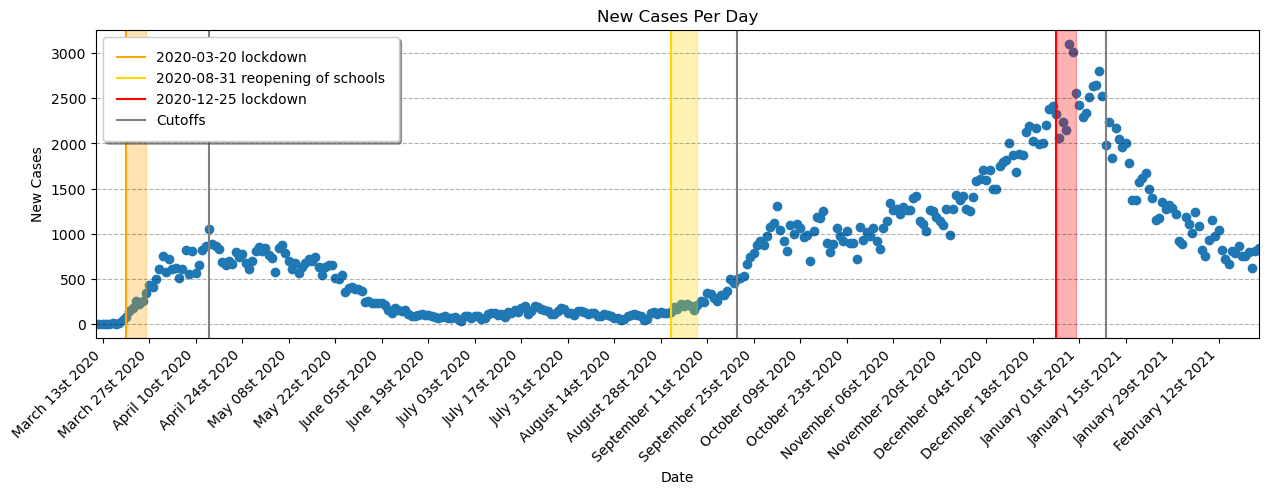

In [18]:
fig, ax = plt.subplots(figsize=(15,4))
overview_plot(ax, data)

/tmp/ipykernel_4493/1998967023.py:23: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=2)


Text(0.5, 1.02, 'Chosen Models For Each Event')

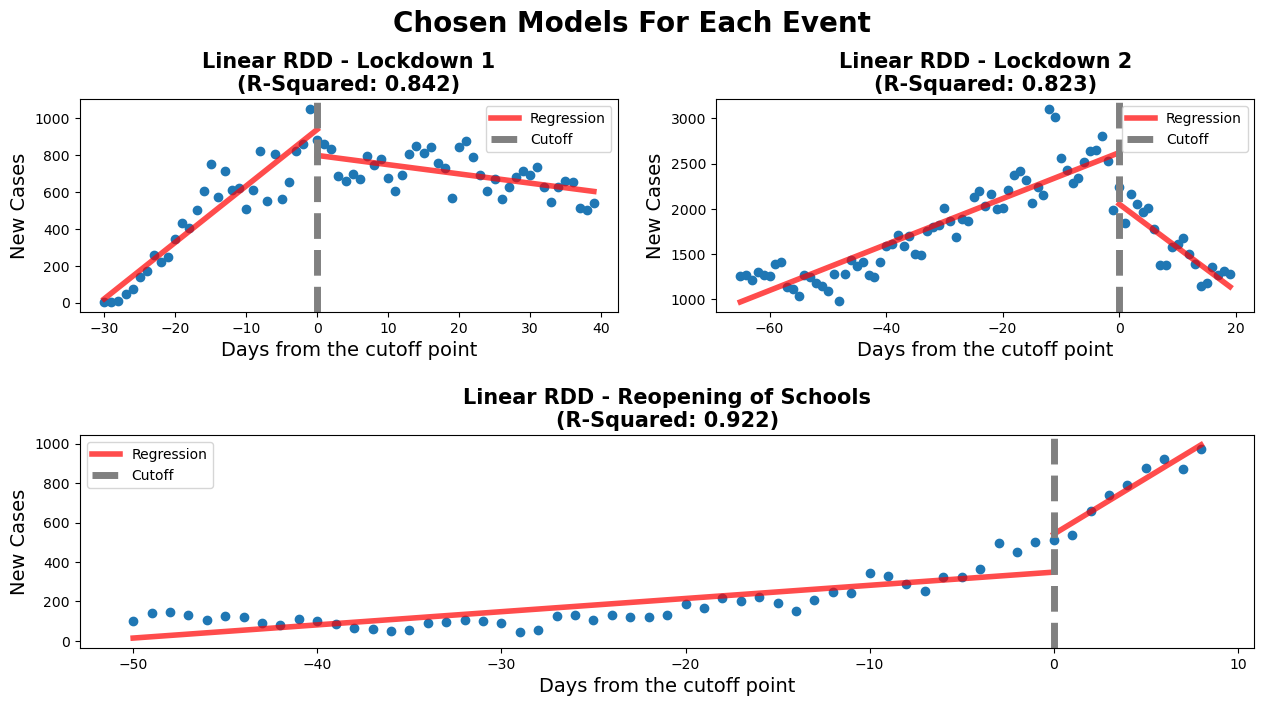

In [19]:
plt.close('all')

gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 2.5], height_ratios=[2, 2])

# create a figure object using the gridspec object
fig = plt.figure(figsize=(13, 7), constrained_layout=True)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# set the position of each subplot using the gridspec object
ax1.set_position(gs[0, 0].get_position(fig))
ax2.set_position(gs[0, 1].get_position(fig))
ax3.set_position(gs[1, :].get_position(fig))

############
rdd_plot(df_rg1, model, ax1, 'Linear RDD - Lockdown 1')
##############
rdd_plot(df_rg3, model3, ax2, 'Linear RDD - Lockdown 2')
################
rdd_plot(df_rg2, model2, ax3, 'Linear RDD - Reopening of Schools')

fig.tight_layout(pad=2)
fig.suptitle('Chosen Models For Each Event', y=1.02 , fontsize=20, weight='bold')

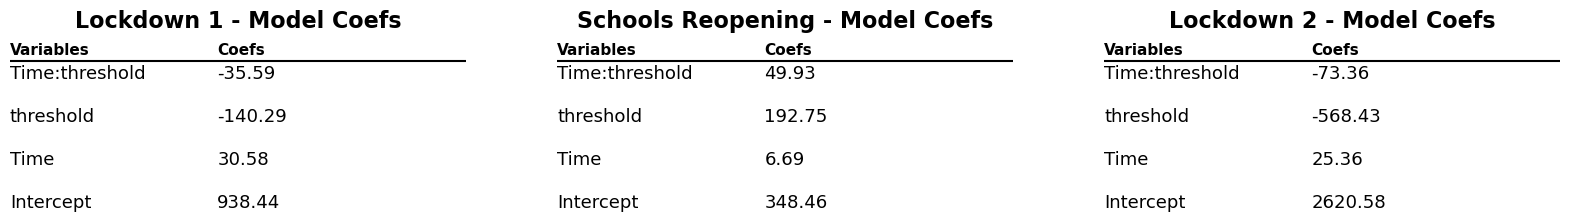

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,2))
c1 = model.params.to_frame().reset_index().rename({'index': 'Variables', 0: 'Coefs'}, axis=1).round(2)
c2 = model2.params.to_frame().reset_index().rename({'index': 'Variables', 0: 'Coefs'}, axis=1).round(2)
c3 = model3.params.to_frame().reset_index().rename({'index': 'Variables', 0: 'Coefs'}, axis=1).round(2)
coef_p_table(fig, ax1, c1, 'Lockdown 1 - Model Coefs')
coef_p_table(fig, ax2, c2, 'Schools Reopening - Model Coefs')
coef_p_table(fig, ax3, c3, 'Lockdown 2 - Model Coefs')

# Model interpretation

## Lockdown 1 analysis

The negative threshold coefficient for this model shows that after the lockdown was put in place there were fewer new cases of COVID-19 per day. The 'Time' coefficient shows that before the lock down the number of new cases were increased at a rate of around 30 a day. After the lockdown was initiated a downward trend in the regression is observed. This is shown by the model when taking into account the values of both 'Time' (30.5) and 'Time:threshold' (-35.6) coefficients. The negative 'Time:threshold: coefficients starts to win over resulting in an overall downward trend. 

This shows that the 1st lockdown was effective in curbing the spread of infection of the COVID-19 virus. The plot shows the ability of the lockdown to 'flatten the curve'. This policy was enacted to prevent the hospitals from being overwhelmed by COVID-19 patients. According to our analysis it was successful in reducing the number of new cases per day. For further analysis hospitalizations could be examined to see if the reduction in new cases per day was mimiced by a reduction in hospitilizations

## School reopening analysis

The school reopening RDD plots show that approaching the reopening date there was a small increase in new daily cases of COVID-19. This is shown by the 'Time' coefficient (6.9) which describes the shallow slope of the line of the first linear regression. After the threshold a drastically different linear regression is observed. This is described by coefficients of the interaction of 'Time:threshold' and 'Time'. The large value of 'Time:threshold: (49.9) compared to the 'Time' coefficient shows just how steep the line following the threshold is. There was a large significant increase in new daily COVID-19 cases after schools were reopened. 

This makes sense with what is known about COVID-19. What is interesting to note is that after the steep increase in daily new cases a plateau is observed (not show in our model). From someone without domain knowledge it can be hard to attribute this observation meaningfully. Perhaps this could be due to a herd immunity being achieved in the schools? Additionally, further analysis of hospitalizations could prove insightful to assess whether the increase in daily cases led to more hospitalizations or if these new cases were non-severe. That is beyond the scope of this project. 

## Lockdown 2 analysis

Before the second lockdown started, there is a clear increase in the number of new covid cases. After the start of the second lockdown, we see a rapid decrease in the number of new covid cases. The values for Time and Time:threshold show that the decrease in new covid cases is more rapid than the increase. The value for Time is around 25 while the value for Time:threshold is around -73. The lockdown 2 RDD plot shows that the second lockdown was effective in decreasing the number of new covid cases.

Unlike after the first lockdown, the second lockdown has a more rapid decrease in the number of new cases. This may be due to the start of the vaccination campaign. Vaccines were not available during the first lockdown, but they were being administered during the second lockdown. Vaccinations start to provide protection two weeks after the initial injection, which coincides with the 2nd lockdown [4]. Also, a portion of the population gained partial immunity, due to previous COVID-19 infections and people adapted to the sanitary norms[5].

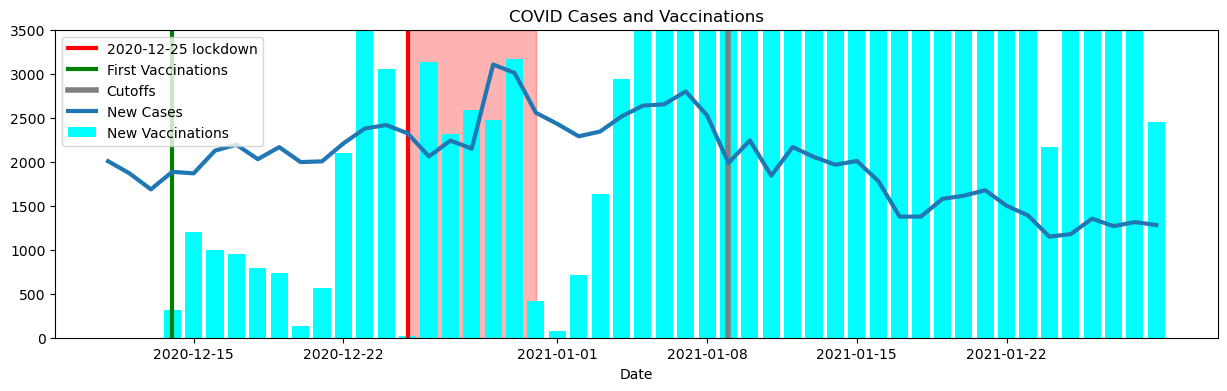

In [22]:
fig, ax = plt.subplots(figsize=(15,4))
vax_plot(ax, data)

### References

Data: “Covid-19 - Portrait Quotidien Des Cas Confirmés - Historique Du Portrait Quotidien Des Cas Confirmés - Données Québec.” COVID-19 - Portrait Quotidien Des Cas Confirmés - Historique Du Portrait Quotidien Des Cas Confirmés - Données Québec, https://www.donneesquebec.ca/recherche/dataset/covid-19-portrait-quotidien-des-cas-confirmes/resource/d2cf4211-5400-46a3-9186-a81e6cd41de9. Accessed 2023-02-21

[1] Tan, W Y T et al. “Does incubation period of COVID-19 vary with age? A study of epidemiologically linked cases in Singapore.” Epidemiology and infection vol. 148 e197. 2 Sep. 2020, doi:10.1017/S0950268820001995

[2] Institut de la statistique du Québec. “Fiches Démographiques – Les Régions Administratives Du Québec.” Institut De La Statistique Du Québec, https://statistique.quebec.ca/fr/document/fiches-demographiques-les-regions-administratives-du-quebec. Accessed 2023-02-23

[2] Tung Ho, Carmen Lok et al. “Clinical Characteristics of Children with COVID-19.” AIMS public health vol. 7,2 258-273. 6 May. 2020, doi:10.3934/publichealth.2020022

[4] “How Quickly Does the Vaccine Work and How Long Does the Protection Last?: Covid-19 Info Vaccines.” COVID, https://www.covid19infovaccines.com/en-posts/how-quickly-does-the-vaccine-work-and-how-long-does-the-protection-last. Accessed 2023-02-23